# Подключение библиотек

In [ ]:
pip install pycocotools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pycocotools.coco import COCO
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from PIL import Image, ImageDraw, ImageFont 
import io
import cv2 
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb 
import skimage.io as io
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont 
import colorsys 

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ZeroPadding2D, Add, UpSampling2D, Concatenate, Lambda, LeakyReLU 
from tensorflow.keras.regularizers import l2 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.models import Model 
from tqdm import tqdm
import colorsys
import tensorflow.keras.backend as K 
import math 
import pandas as pd
import tensorflow as tf 
import numpy as np 
import time 
from tensorflow.keras import utils 

In [ ]:
from google.colab import drive 
from google.colab import files 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q '/content/drive/My Drive/База картинок/annotations_trainval2017.zip'

In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip

--2022-07-03 15:38:15--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.33.233
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.33.233|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  69.7MB/s    in 3m 53s  

2022-07-03 15:42:08 (79.2 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]



In [ ]:
!unzip -q 'train2017.zip'

In [ ]:
DATA_PATH='/content/drive/My Drive/База картинок/output/'

In [ ]:
img_dir='train2017/'

# Подключение дата-сета

In [ ]:
dataType='train2017'
annFile='annotations/instances_{}.json'.format(dataType)
coco=COCO(annFile)

loading annotations into memory...
Done (t=22.00s)
creating index...
index created!


In [ ]:
annFile = 'annotations/person_keypoints_{}.json'.format(dataType)
coco_kps=COCO(annFile)

loading annotations into memory...
Done (t=10.02s)
creating index...
index created!


In [ ]:
catIds = coco.getCatIds(catNms=['person'])
imgIds = coco.getImgIds(catIds=catIds) #len = 64115

In [ ]:
unique_images = []
unique_anns = []
for i in range(1000):
  img = coco.loadImgs(imgIds[i])[0]
  path = os.path.join(img_dir, img['file_name'])
  image_open = Image.open(path)
  image_open.save(DATA_PATH + 'image/'+'{}.jpg'.format(i))

  image = np.array(image_open)
  unique_images.append(image)
  anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
  anns = coco.loadAnns(anns_ids)
  unique_anns.append(anns)

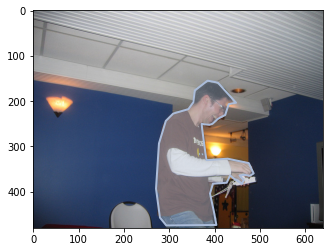

In [ ]:
plt.imshow(unique_images[12]) # оригинальное изображение
coco.showAnns(unique_anns[12]) # анотация изображение

In [ ]:
for j in range(0,len(unique_anns)):
  ind=unique_anns[j]
  mask = coco.annToMask(ind[0])
  name_img = str(j)+str('.jpg')  
  mask_save = Image.fromarray(mask * 255, mode = "L")
  mask_save.save(DATA_PATH + 'segment/' + name_img)

In [ ]:
dictionary = {}
box_param=[]
class_id = 0
for i in os.listdir(DATA_PATH + 'segment/'):
  image = Image.open(DATA_PATH+'segment/'+i)
  color_mask = np.array(image) 
  indexes = np.where(color_mask > 230) 
  xy=[min(indexes[1]), min(indexes[0]), max(indexes[1]), max(indexes[0])]

  dictionary[i] = 'image/'+i+' '+str (xy[0]) +',' + str(xy[1])+','+str(xy[2])+','+str(xy[3])+','+str(class_id)

In [ ]:
dictionary_np = np.array(list(dictionary.values())) 
np.random.seed(17)
np.random.shuffle(dictionary_np)
np.random.seed(None)
num_val = int(len(dictionary_np) * 0.1) 
num_test=int(len(dictionary_np) * 0.1) 
num_train = int(len(dictionary_np) - num_test -num_val)

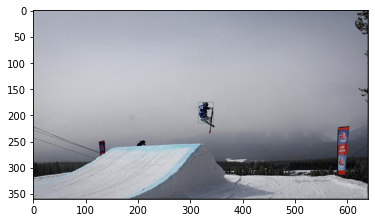

In [ ]:
data=dictionary_np[900]
data = data.split() 
image = Image.open(DATA_PATH + data[0]) 
ram=data[1].split(',') 
ram1=int(ram[0])
ram2=int(ram[1])
ram3=int(ram[2])
ram4=int(ram[3])

draw_2 = ImageDraw.Draw(image)
draw_2.rectangle([ram1,ram2,ram3,ram4], outline='grey')
plt.imshow(image)

# Подготовка данных

In [ ]:
anchors = np.array([[10, 13], [16, 30], [33, 23], [30, 61], [62, 45], [59, 119], [116, 90], [156, 198], [373, 326]]) #стандартные значения для 416*416
num_anchors = len(anchors) 
batch_size = 300
name_classes = ['Human'] 
num_classes = len(name_classes) 
input_shape = (416, 416) 

In [ ]:
def data_generator(annotation_lines, batch_size, anchors, input_shape):
    n = len(annotation_lines)
    i = 0
    while True:
        image_data = [] 
        box_data = [] 
        for b in range(batch_size): 
            if i==0: 
                np.random.shuffle(annotation_lines) 
            image, box = augmentation(annotation_lines[i]) 
            image_data.append(image) 
            box_data.append(box) 
            i = (i+1) % n 
        image_data = np.array(image_data) 
        box_data = np.array(box_data) 
        y_true = get_y(box_data, anchors, input_shape)       
        yield [image_data, *y_true], np.zeros(batch_size)

In [ ]:
def augmentation(data):
    params = {
        'jitter' : .3,
        'hue'    : .1,
        'sat'    : 1.5,
        'val'    : 1.5
    }
    
    data = data.split() 
    image = Image.open(DATA_PATH + data[0]) 
    width_i, height_i = image.size 
    widht_shape, height_shape = input_shape[:2] 
    box = np.array([np.array(list(map(lambda x: int(float(x)),box.split(',')))) for box in data[1:]])
    
    new_ar = widht_shape / height_shape * rand(1 - params['jitter'], 1 + params['jitter']) / rand(1 - params['jitter'], 1 + params['jitter'])
    scale = rand(.65, 2) 
    if new_ar < 1:        
        nh = int(scale * height_shape)
        nw = int(nh * new_ar)
    else:
        nw = int(scale * widht_shape)
        nh = int(nw / new_ar)
    image = image.resize((nw, nh), Image.BICUBIC)
    
    dx = int(rand(0, widht_shape - nw))
    dy = int(rand(0, height_shape - nh))
    new_image = Image.new('RGB', (widht_shape, height_shape), (128,128,128))
    new_image.paste(image, (dx, dy))
    image = new_image

    flip = rand() < .5
    if flip:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
    
    hue1 = rand(-params['hue'], params['hue'])
    sat1 = rand(1, params['sat']) if rand() < .5 else 1 / rand(1, params['sat'])
    val1 = rand(1, params['val']) if rand() < .5 else 1 / rand(1, params['val'])
    x = rgb_to_hsv(np.array(image) / 255.)
    x[..., 0] += hue1
    x[..., 0][x[..., 0] > 1] -= 1
    x[..., 0][x[..., 0] < 0] += 1
    x[..., 1] *= sat1
    x[..., 2] *= val1
    x[x > 1] = 1
    x[x < 0] = 0
    image_data = hsv_to_rgb(x) 
    
    max_boxes = 4 
    box_data = np.zeros((max_boxes,5)) 
    if len(box)>0:      
        box[:, [0,2]] = box[:, [0,2]] * nw/width_i + dx
        box[:, [1,3]] = box[:, [1,3]] * nh/height_i + dy
        if flip: box[:, [0,2]] = widht_shape - box[:, [2,0]]
        box[:, 0:2][box[:, 0:2]<0] = 0
        box[:, 2][box[:, 2] > widht_shape] = widht_shape
        box[:, 3][box[:, 3] > height_shape] = height_shape
        box_w = box[:, 2] - box[:, 0] 
        box_h = box[:, 3] - box[:, 1] 
        box = box[np.logical_and(box_w > 1, box_h > 1)]
        if len(box) > max_boxes: 
            box = box[:max_boxes]
        box_data[:len(box)] = box 

    return image_data, box_data 

In [ ]:
def get_y(true_boxes, anchors, input_shape):
    num_layers = len(anchors) // 3 
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] 

    true_boxes = np.array(true_boxes, dtype='float32') 
    input_shape = np.array(input_shape, dtype='int32') 
    boxes_xy = (true_boxes[..., 0:2] + true_boxes[..., 2:4]) // 2 
    boxes_wh = true_boxes[..., 2:4] - true_boxes[..., 0:2]
    true_boxes[..., 0:2] = boxes_xy / input_shape[::-1] 
    true_boxes[..., 2:4] = boxes_wh / input_shape[::-1] 

    m = true_boxes.shape[0] 
    grid_shapes = [input_shape//{0:32, 1:16, 2:8}[l] for l in range(num_layers)] 


    y_true = [np.zeros((m,grid_shapes[l][0],grid_shapes[l][1],len(anchor_mask[l]),5+num_classes),
        dtype='float32') for l in range(num_layers)]
    anchors = np.expand_dims(anchors, 0) 
    anchor_maxes = anchors / 2. 
    anchor_mins = -anchor_maxes
    valid_mask = boxes_wh[..., 0] > 0

    for b in range(m):
        wh = boxes_wh[b, valid_mask[b]] 
        if len(wh)==0: continue 
        wh = np.expand_dims(wh, -2) 
        
        box_maxes = wh / 2.
        box_mins = -box_maxes
        
        intersect_mins = np.maximum(box_mins, anchor_mins) 
        intersect_maxes = np.minimum(box_maxes, anchor_maxes)
        intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
        intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
        box_area = wh[..., 0] * wh[..., 1]
        anchor_area = anchors[..., 0] * anchors[..., 1]
        iou = intersect_area / (box_area + anchor_area - intersect_area)

        best_anchor = np.argmax(iou, axis=-1) 

        for t, n in enumerate(best_anchor): 
            for l in range(num_layers):
                if n in anchor_mask[l]:
                    i = np.floor(true_boxes[b,t,0] * grid_shapes[l][1]).astype('int32')
                    j = np.floor(true_boxes[b,t,1] * grid_shapes[l][0]).astype('int32')
                    k = anchor_mask[l].index(n)
                    c = true_boxes[b,t, 4].astype('int32')
                    y_true[l][b, j, i, k, 0:4] = true_boxes[b,t, 0:4]
                    y_true[l][b, j, i, k, 4] = 1
                    y_true[l][b, j, i, k, 5+c] = 1
    return y_true

In [ ]:
def rand(a=0, b=1):
  return np.random.rand()*(b-a) + a

In [ ]:
train_data = data_generator(dictionary_np[:num_train], batch_size, anchors, input_shape)
validation_data = data_generator(dictionary_np[num_train:num_train+num_val], batch_size, anchors, input_shape)

# Создание модели 

In [ ]:
def create_model(
        input_shape,
        num_anchors,
        use_weights = False): 
    w, h = input_shape 
    inputs = Input(shape = (w, h, 3)) 
    y_true = [Input (shape = (w // 32, h // 32, num_anchors // 3, num_classes + 5))] 
    y_true.append (Input (shape = (w // 16, h // 16, num_anchors // 3, num_classes + 5))) 
    y_true.append (Input (shape = (w // 8, h // 8, num_anchors // 3, num_classes + 5))) 
    
    model_yolo = create_YOLOv3(inputs, num_anchors // 3) 
    print ('Создана модель YOLOv3. Количество классов: {}.'.format(num_classes)) 
    outputs = Lambda(yolo_loss, output_shape = (1,), name = 'yolo_loss', arguments = {'num_anchors' : num_anchors}) ([*model_yolo.output, *y_true])
    
    return Model([inputs, *y_true], outputs) 

In [ ]:
def create_YOLOv3(
        inputs,
        num_sub_anchors
        ):
    x = ConvBL (inputs, 32, (3, 3)) 
    x = resblock (x, 64, 1) 
    x = resblock (x, 128, 2) 
    x = resblock (x, 256, 8) 
    x = resblock (x, 512, 8) 
    x = resblock (x, 1024, 4) 
    base_model = Model(inputs, x) 

    x = ConvBL(base_model.output, 512, (1, 1))    
    x = ConvBL(x, 1024, (3, 3))
    x = ConvBL(x, 512, (1, 1))
    x = ConvBL(x, 1024, (3, 3))
    x = ConvBL(x, 512, (1, 1))

    y1 = ConvBL(x, 1024, (3,3))
    y1 = Conv2D(num_sub_anchors * (num_classes + 5), (1, 1), padding = 'same', kernel_regularizer = l2(5e-4)) (y1)
    
    x = ConvBL(x, 256, ( 1, 1)) 
    x = UpSampling2D(2) (x) 
    x = Concatenate()([x,base_model.layers[152].output])

    x = ConvBL(x, 256, (1, 1))  
    x = ConvBL(x, 512, (3, 3))
    x = ConvBL(x, 256, (1, 1))
    x = ConvBL(x, 512, (3, 3))
    x = ConvBL(x, 256, (1, 1))
    
    y2 = ConvBL(x, 512, (3, 3))
    y2 = Conv2D(num_sub_anchors * (num_classes + 5), (1, 1), padding = 'same', kernel_regularizer = l2(5e-4)) (y2)
    
    x = ConvBL(x, 128, ( 1, 1)) 
    x = UpSampling2D(2) (x)  
    x = Concatenate()([x,base_model.layers[92].output])
    
    x = ConvBL(x, 128, (1, 1))  
    x = ConvBL(x, 256, (3, 3))
    x = ConvBL(x, 128, (1, 1))
    x = ConvBL(x, 256, (3, 3))
    x = ConvBL(x, 128, (1, 1))
    
    y3 = ConvBL(x, 256, (3, 3))
    y3 = Conv2D(num_sub_anchors * (num_classes + 5), (1, 1), padding = 'same', kernel_regularizer = l2(5e-4)) (y3)
    
    return Model(inputs, [y1, y2, y3]) 

In [ ]:
def resblock(
        inputs,
        num_filters,
        num_blocks
        ):
    x = ZeroPadding2D(((1, 0), (1, 0)))(inputs)
    x = ConvBL(x, num_filters, (3, 3), strides=(2, 2)) 
    for i in range(num_blocks): 
        y = ConvBL(x, num_filters // 2, (1, 1))
        y = ConvBL(y, num_filters, (3, 3))
        x = Add() ([x, y])
    return x 

In [ ]:
def ConvBL(
        inputs,
        *args,
        **kwargs
        ): 
    new_kwargs = {'use_bias': False} 
    new_kwargs['kernel_regularizer'] = l2(5e-4) 
    new_kwargs['padding'] = 'valid' if kwargs.get('strides') == (2, 2) else 'same' 
    new_kwargs.update(kwargs)
    x = Conv2D(*args, **new_kwargs) (inputs) 
    x = BatchNormalization() (x) 
    x = LeakyReLU(alpha=0.1) (x) 
    return x

In [ ]:
def yolo_loss(
      inputs,
      num_anchors
      ):
    ignore_thresh = .5 
    num_layers = num_anchors // 3 
    y_pred = inputs[:num_layers] 
    y_true = inputs[num_layers:] 
    anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]] 

    input_shape = K.cast(K.shape(y_pred[0])[1:3] * 32, K.dtype(y_true[0])) 
    
    grid_shapes = [K.cast(K.shape(y_pred[l])[1:3], K.dtype(y_true[0])) for l in range(num_layers)]
    
    loss = 0 
    
    m = K.shape(y_pred[0])[0] 
    batch_size = K.cast(m, K.dtype(y_pred[0])) 
    
    for l in range(num_layers): 
        object_mask = y_true[l][..., 4:5] 
        true_class = y_true[l][..., 5:]         
        num_sub_anchors = len(anchors[anchor_mask[l]]) 
        anchors_tensor = K.reshape(K.constant(anchors[anchor_mask[l]]), [1, 1, 1, num_sub_anchors, 2])
        
        grid_shape = K.shape(y_pred[l])[1:3] 
        grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),[1, grid_shape[1], 1, 1])
        grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),[grid_shape[0], 1, 1, 1]) 
        grid = K.concatenate([grid_x, grid_y]) 
        grid = K.cast(grid, K.dtype(y_pred[l])) 
        
        feats = K.reshape(y_pred[l], [-1, grid_shape[0], grid_shape[1], num_sub_anchors, num_classes + 5]) 
        
        pred_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[::-1], K.dtype(feats)) 
        true_xy = y_true[l][..., :2] * grid_shapes[l][::-1] - grid 
        box_loss_scale = 2 - y_true[l][...,2:3] * y_true[l][...,3:4] 
        xy_loss = object_mask * box_loss_scale * K.binary_crossentropy(true_xy, feats[...,0:2], from_logits=True)
 
        pred_wh = K.exp(feats[..., 2:4]) * anchors_tensor / K.cast(input_shape[::-1], K.dtype(feats)) 
        true_wh = K.log(y_true[l][..., 2:4] / anchors[anchor_mask[l]] * input_shape[::-1]) 
        true_wh = K.switch(object_mask, true_wh, K.zeros_like(true_wh)) 
        wh_loss = object_mask * box_loss_scale * 0.5 * K.square(true_wh-feats[...,2:4])
        
        pred_box = K.concatenate([pred_xy, pred_wh]) 
        ignore_mask = tf.TensorArray(K.dtype(y_true[0]), size=1, dynamic_size=True) 
        object_mask_bool = K.cast(object_mask, 'bool') 

        def loop_body(
                b,
                ignore_mask
                ):
            true_box = tf.boolean_mask(y_true[l][b,...,0:4], object_mask_bool[b,...,0]) 
            iou = calc_iou(pred_box[b], true_box) 
            best_iou = K.max(iou, axis=-1) 
            ignore_mask = ignore_mask.write(b, K.cast(best_iou < ignore_thresh, K.dtype(true_box))) 
            return b+1, ignore_mask 
        
        _, ignore_mask = tf.while_loop(lambda b,*args: b<m, loop_body, [0, ignore_mask]) 
        ignore_mask = ignore_mask.stack() 
        ignore_mask = K.expand_dims(ignore_mask, -1) 
        confidence_loss = (
            object_mask * K.binary_crossentropy(object_mask, feats[...,4:5], from_logits=True) +
            (1-object_mask) * K.binary_crossentropy(object_mask, feats[...,4:5], from_logits=True) * ignore_mask
            )
        
        class_loss = object_mask * K.binary_crossentropy(true_class, feats[...,5:], from_logits=True)
        xy_loss = K.sum(xy_loss) / batch_size
        wh_loss = K.sum(wh_loss) / batch_size
        confidence_loss = K.sum(confidence_loss) / batch_size
        class_loss = K.sum(class_loss) / batch_size
        loss += xy_loss + wh_loss + confidence_loss + class_loss
                
    return loss  

In [ ]:
def calc_iou(input1, input2):
    input1 = K.expand_dims(input1, -2) 
    xy1 = input1[..., :2] 
    wh1 = input1[..., 2:4]
    wh_half1 = wh1 / 2. 
    top_left1 = xy1 - wh_half1 
    right_bottom1 = xy1 + wh_half1
    
    input2 = K.expand_dims(input2, 0) 
    xy2 = input2[..., :2] 
    wh2 = input2[..., 2:4] 
    wh_half2 = wh2 / 2. 
    top_left2 = xy2 - wh_half2 
    right_bottom2 = xy2 + wh_half2
    
    intersect_mins = K.maximum(top_left1, top_left2)
    intersect_maxes = K.minimum(right_bottom1, right_bottom2)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1] 
    
    area1 = wh1[..., 0] * wh1[..., 1] 
    area2 = wh2[..., 0] * wh2[..., 1]
    
    return intersect_area / (area1 + area2 - intersect_area) 

In [ ]:
batch_size = 8
model_YOLO = create_model(input_shape, num_anchors, use_weights=True)
lr_value = 1e-3
model_YOLO.compile(optimizer=Adam(lr=lr_value), loss={'yolo_loss':lambda y_true, y_pred: y_pred})

Создана модель YOLOv3. Количество классов: 1.


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Обучение модели 

In [ ]:
model_filename = DATA_PATH +'YOLOv3_100.h5'
history = model_YOLO.fit_generator(train_data, steps_per_epoch = max (1, num_train//batch_size),validation_data = validation_data ,validation_steps = max (1, num_val//batch_size),epochs = 10,verbose = 1,initial_epoch = 0)
model_YOLO.save_weights(model_filename) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
100/100 [==============================] - 1038s 10s/step - loss: 838.2742 - val_loss: 5735600.0000
Epoch 2/10
100/100 [==============================] - 1015s 10s/step - loss: 78.8252 - val_loss: 80.0296
Epoch 3/10
100/100 [==============================] - 1012s 10s/step - loss: 53.8663 - val_loss: 47.0267
Epoch 4/10
100/100 [==============================] - 1003s 10s/step - loss: 41.8884 - val_loss: 37.7116
Epoch 5/10
100/100 [==============================] - 1003s 10s/step - loss: 34.8874 - val_loss: 77.1854
Epoch 6/10
100/100 [==============================] - 996s 10s/step - loss: 32.5788 - val_loss: 3346854.2500
Epoch 7/10
100/100 [==============================] - 995s 10s/step - loss: 29.2663 - val_loss: 15790.8975
Epoch 8/10
100/100 [==============================] - 996s 10s/step - loss: 29.2259 - val_loss: 358.7872
Epoch 9/10
100/100 [==============================] - 1002s 10s/step - loss: 28.2276 - val_loss: 28.5667
Epoch 10/10
100/100 [======================

# Тестирование модели 

In [ ]:
test_data=dictionary_np[num_train+num_val:]
data=test_data[95] 
data = data.split() 
image = Image.open(DATA_PATH + data[0])

iw, ih = image.size
w, h = (416, 416)
scale = min(w / iw, h / ih)
nw = int(iw * scale)
nh = int(ih * scale)
image_for_predict = image.resize((nw, nh), Image.BICUBIC)
new_image = Image.new('RGB', (416,416), (128, 128, 128))
new_image.paste(image_for_predict, ((w - nw) // 2, (h - nh) // 2))
image_for_predict = new_image 
image_for_predict = np.array(image_for_predict) / 255.
image_for_predict = image_for_predict.reshape(1, 416, 416, 3)

In [ ]:
max_boxes = 5 
model_YOLO = create_YOLOv3(Input(shape=(416, 416, 3)), 9//3) 
model_YOLO.load_weights(model_filename) 
predict = model_YOLO.predict(image_for_predict)
num_layers = len(predict) 

In [ ]:
hsv_tuples = [(x / len(name_classes), 1., 1.) for x in range(len(name_classes))]
colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
colors = list(map(lambda x:(int(x[0]*255), int(x[1]*255), int(x[2]*255)), colors))
np.random.seed(43)
np.random.shuffle(colors)
np.random.seed(None)

In [ ]:
anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] 
input_shape = np.array(predict[0].shape[1:3]) * 32  
image_shape = np.array([image.size[1], image.size[0]]) 
print(input_shape)
print(image_shape)

[416 416]
[458 640]


In [ ]:
level_anchor = 0 
num_anchors = len(anchors[anchor_mask[level_anchor]]) 
anchors_tensor = np.reshape(anchors[anchor_mask[level_anchor]], (1,1,1,num_anchors,2)) 
print(anchors_tensor.shape)
print(anchors_tensor)

(1, 1, 1, 3, 2)
[[[[[116  90]
    [156 198]
    [373 326]]]]]


In [ ]:
grid_shape = predict[level_anchor].shape[1:3] 
grid = []
grid_row = [] 
for i in range(grid_shape[0]): 
  for j in range(grid_shape[1]): 
    grid_row.append([j , i]) 
  grid.append(grid_row) 
  grid_row = [] 
grid = np.array(grid) 
grid = np.expand_dims(grid, axis=2) 
print(grid.shape) 

(13, 13, 1, 2)


In [ ]:
feats = np.reshape(predict[level_anchor], (-1, grid_shape[0], grid_shape[1], num_anchors, num_classes+5))
print(feats.shape)
print (feats[0][6][7][1])

(1, 13, 13, 3, 6)
[ 0.40317407  0.12658618  0.41398817  0.07008986 -6.03767     6.814767  ]


In [ ]:
print (feats[0][2][2][2])

[-0.516886   -0.8550577  -0.29306462 -0.14061445 -7.055556    6.8911676 ]


In [ ]:
def sigmoid(x):
  return 1/(1+np.exp(-x)) 

In [ ]:
xy_param = feats[..., :2] 
box_xy = (sigmoid(xy_param) + grid)/grid_shape[::-1]

wh_param = feats[..., 2:4] 
box_wh = np.exp(wh_param) * anchors_tensor / input_shape[::-1]

conf_param = feats[..., 4:5] 
box_confidence = sigmoid(conf_param) 

class_param = feats[...,5:] 
box_class_probs = sigmoid(class_param) 
print(box_xy.shape)
print(box_wh.shape)
print(box_confidence.shape)
print(box_class_probs.shape)
print(box_xy[0][6][7][1])
print(box_wh[0][6][7][1])
print(box_confidence[0][6][7][1])
print(box_class_probs[0][6][7][1])

(1, 13, 13, 3, 2)
(1, 13, 13, 3, 2)
(1, 13, 13, 3, 1)
(1, 13, 13, 3, 1)
[0.58457308 0.5024311 ]
[0.5673147  0.51051851]
[0.00238143]
[0.99890375]


In [ ]:
box_yx = box_xy[..., ::-1].copy()
box_hw = box_wh[..., ::-1].copy()

new_shape = np.round(image_shape * np.min(input_shape/image_shape))
offset = (input_shape-new_shape)/2./input_shape 
scale = input_shape/new_shape  
box_yx = (box_yx - offset) * scale 
box_hw *= scale 

box_mins = box_yx - (box_hw / 2.) 
box_maxes = box_yx + (box_hw / 2.) 
_boxes =  np.concatenate([
    box_mins[..., 0:1], 
    box_mins[..., 1:2], 
    box_maxes[..., 0:1], 
    box_maxes[..., 1:2]  
], axis=-1)
print(new_shape)
print(offset)
print(scale)
print(_boxes.shape)
print()
print(_boxes[0][6][7][1])
print(image_shape)
_boxes *= np.concatenate([image_shape, image_shape]) 
print(_boxes[0][6][7][1])


[298. 416.]
[0.14182692 0.        ]
[1.39597315 1.        ]
(1, 13, 13, 3, 4)

[0.14705869 0.30091573 0.85972882 0.86823043]
[458 640]
[ 67.35288064 192.58606801 393.75579955 555.66747555]


In [ ]:
_boxes_reshape = np.reshape(_boxes, (-1, 4)) 
_box_scores = box_confidence * box_class_probs 
_box_scores_reshape = np.reshape(_box_scores, (-1, num_classes)) 
print(_boxes_reshape.shape)
print(_box_scores_reshape.shape)
print(_boxes_reshape[256])
print(_box_scores_reshape[256]) 

(507, 4)
(507, 1)
[ 67.35288064 192.58606801 393.75579955 555.66747555]
[0.00237882]


In [ ]:
mask = _box_scores_reshape >= 0.0027 
print(np.where(mask == True))

(array([244, 247, 250, 286]), array([0, 0, 0, 0]))


In [ ]:
_boxes_out = _boxes_reshape[mask[:,0]]
_scores_out = _box_scores_reshape[:, 0][mask[:,0]] 
classes_out = np.ones_like(_scores_out,'int32') * 0
print(_boxes_out)
print(_scores_out)
print (classes_out)

[[ 61.14812284   6.81231572 400.61265946 348.54846074]
 [ 57.97616741  56.95927547 404.31022588 397.26948665]
 [ 58.87246722 102.59750219 403.41276522 449.74178167]
 [110.06575023  49.42397961 450.19708385 403.99802098]]
[0.00274553 0.0028756  0.00278134 0.00276801]
[0 0 0 0]


In [ ]:
thickness = (image.size[0] + image.size[1]) // 300

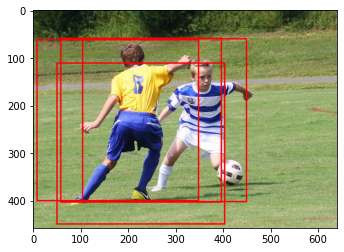

In [ ]:
image_pred = image.copy()
for i, c in reversed(list(enumerate(classes_out))):
  draw = ImageDraw.Draw(image_pred)
  predicted_class = name_classes[c]
  box = _boxes_out[i]
  score = _scores_out[i]
  top, left, bottom, right = box
  top = max(0, np.floor(top + 0.5).astype('int32'))
  left = max(0, np.floor(left + 0.5).astype('int32'))
  bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
  right = min(image.size[0], np.floor(right + 0.5).astype('int32'))  
  for i in range(thickness):
      draw.rectangle(
          [left + i, top + i, right - i, bottom - i],
          outline=colors[c])
  del draw

plt.imshow(image_pred)